In [2]:
# ============================================================
# Phase 5 — Explainability & Insights (Notebook Version)
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shap
from sklearn.inspection import PartialDependenceDisplay

In [3]:
# Make plots appear in notebook
%matplotlib inline

shap.initjs()

In [4]:
# ------------------------------------------------------------
# 1) Load dataset
# ------------------------------------------------------------
FEATURE_PATH = "../data_engineer/processed/glp1_features.csv"
df = pd.read_csv(FEATURE_PATH)

print("Full dataset shape:", df.shape)

# Use automatic sample for faster SHAP (10,000 rows)
SAMPLE_SIZE = 10000
df_sample = df.sample(n=min(SAMPLE_SIZE, len(df)), random_state=42).reset_index(drop=True)

print("Using sample for explainability:", df_sample.shape)

# Separate features and target
y = df_sample["label"] if "label" in df_sample.columns else df_sample["seriousness"]
X = df_sample.drop(columns=["label", "seriousness"], errors="ignore")

Full dataset shape: (262553, 30)
Using sample for explainability: (10000, 30)


In [5]:
# ------------------------------------------------------------
# 2) Train-test split
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (8000, 28)
Test shape: (2000, 28)


In [6]:
# ------------------------------------------------------------
# 3) Train RandomForest
# ------------------------------------------------------------
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)
rf.fit(X_train, y_train)
print("RandomForest training complete.")

RandomForest training complete.


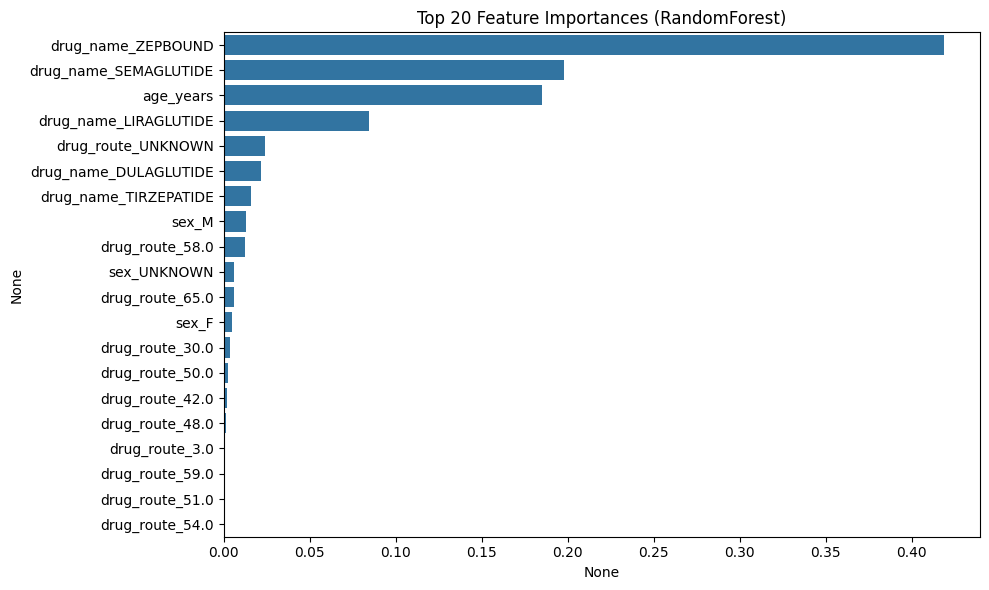

In [7]:
# ------------------------------------------------------------
# 4) Feature Importance (Visualization)
# ------------------------------------------------------------
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.head(20), y=importances.head(20).index)
plt.title("Top 20 Feature Importances (RandomForest)")
plt.tight_layout()
plt.show()

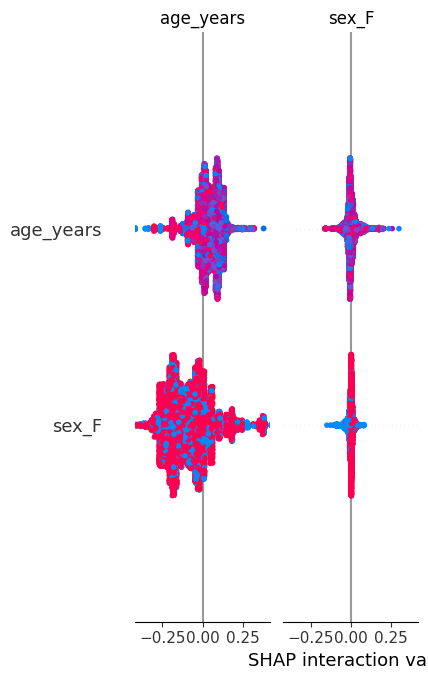

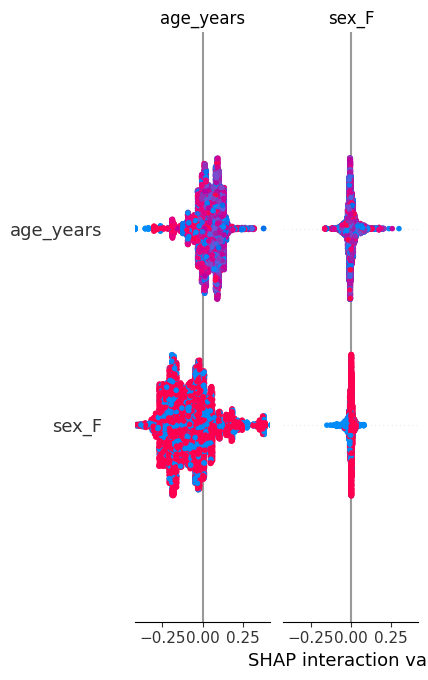

In [8]:
# ------------------------------------------------------------
# 5) SHAP Analysis
# ------------------------------------------------------------
explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_train)

# Summary bar plot
shap.summary_plot(shap_values.values, X_train, plot_type="bar")

# Detailed summary plot
shap.summary_plot(shap_values.values, X_train)

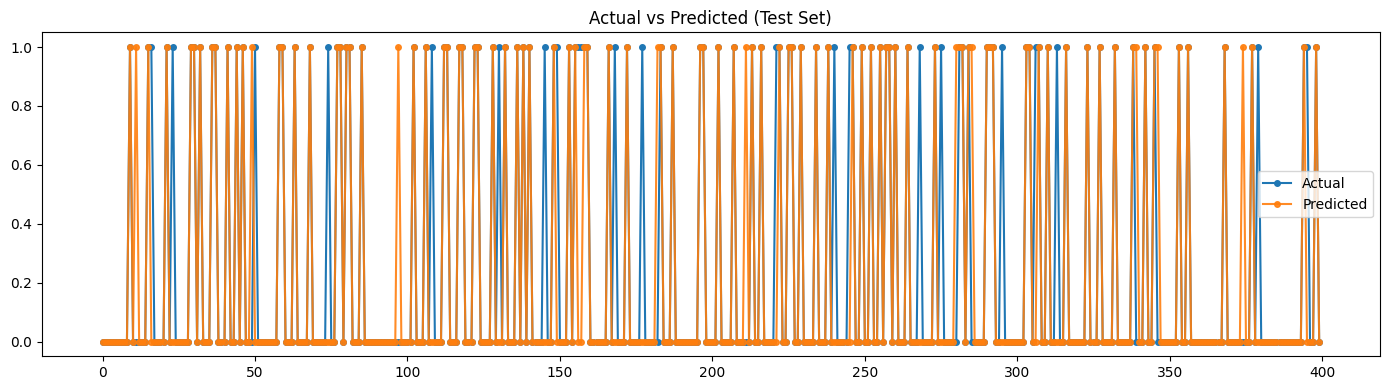

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1484
           1       0.85      0.84      0.84       516

    accuracy                           0.92      2000
   macro avg       0.90      0.89      0.90      2000
weighted avg       0.92      0.92      0.92      2000



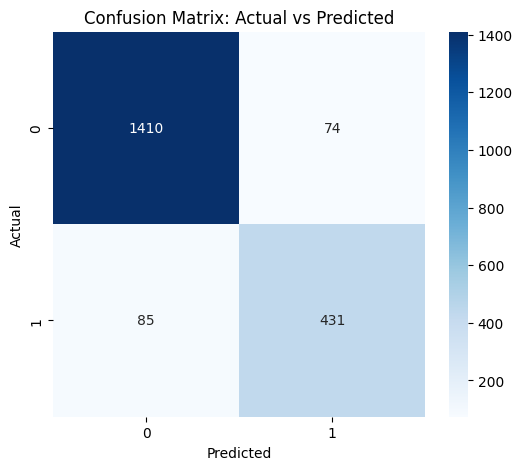

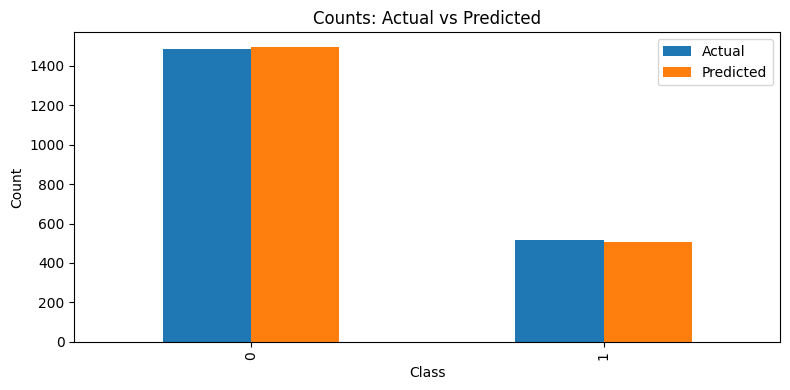

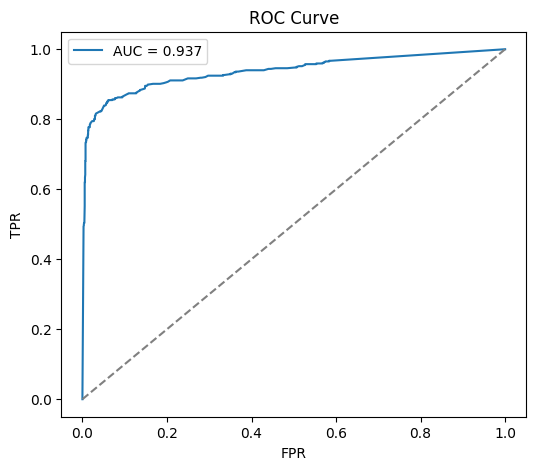

In [8]:
# ------------------------------------------------------------
# 6) Actual vs Predicted Visualizations
# ------------------------------------------------------------
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Ensure model and test split exist: X_test, y_test, rf
y_pred = rf.predict(X_test)

# Try to get predicted probabilities for ROC if available
y_proba = None
try:
    # for binary classification take column 1
    proba = rf.predict_proba(X_test)
    if proba.ndim == 2 and proba.shape[1] == 2:
        y_proba = proba[:, 1]
    else:
        y_proba = proba
except Exception:
    y_proba = None

# --- Time-series style Actual vs Predicted (line plot) ---
# If there is a date-like column in X_test (e.g. 'receivedate' or 'date'), use it as x-axis; otherwise use the sample index.
date_col = None
for c in ['receivedate', 'date', 'report_date']:
    if c in X_test.columns:
        date_col = c
        break

if date_col is not None:
    try:
        x_axis = pd.to_datetime(X_test[date_col]).reset_index(drop=True)
    except Exception:
        x_axis = pd.RangeIndex(start=0, stop=len(y_test))
else:
    x_axis = pd.RangeIndex(start=0, stop=len(y_test))

df_plot = pd.DataFrame({'Actual': pd.Series(y_test).reset_index(drop=True), 'Predicted': pd.Series(y_pred)})

# Limit points for readability (adjust MAX_POINTS as needed)
MAX_POINTS = 400
if len(df_plot) > MAX_POINTS:
    df_plot = df_plot.iloc[:MAX_POINTS].reset_index(drop=True)
    x_axis = x_axis[:MAX_POINTS]

plt.figure(figsize=(14,4))
plt.plot(x_axis, df_plot['Actual'], marker='o', linestyle='-', markersize=4, label='Actual', color='tab:blue')
plt.plot(x_axis, df_plot['Predicted'], marker='o', linestyle='-', markersize=4, label='Predicted', color='tab:orange', alpha=0.9)
plt.title('Actual vs Predicted (Test Set)')
plt.legend()
plt.tight_layout()
plt.show()

# Print classification report
print("Classification report:")
print(classification_report(y_test, y_pred))

# Confusion matrix (counts)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Actual vs Predicted')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Counts comparison by class
counts = pd.DataFrame({'Actual': pd.Series(y_test).value_counts().sort_index(), 'Predicted': pd.Series(y_pred).value_counts().sort_index()}).fillna(0)
counts.plot(kind='bar', figsize=(8,4))
plt.title('Counts: Actual vs Predicted')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# ROC curve for binary classification if probabilities available
if y_proba is not None and len(np.unique(y_test)) == 2:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()


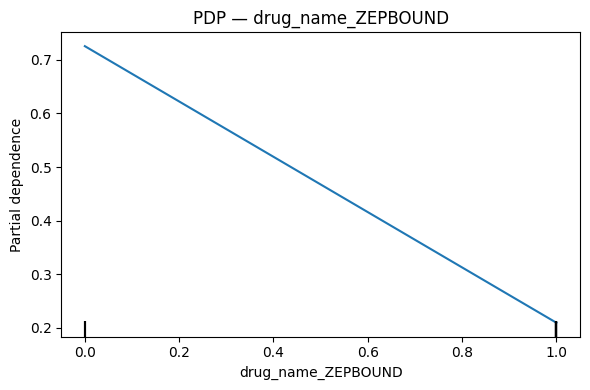

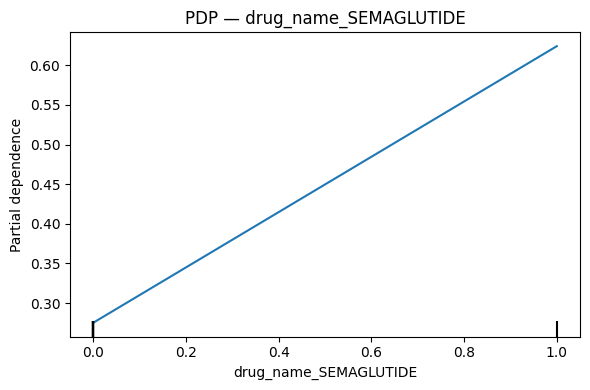

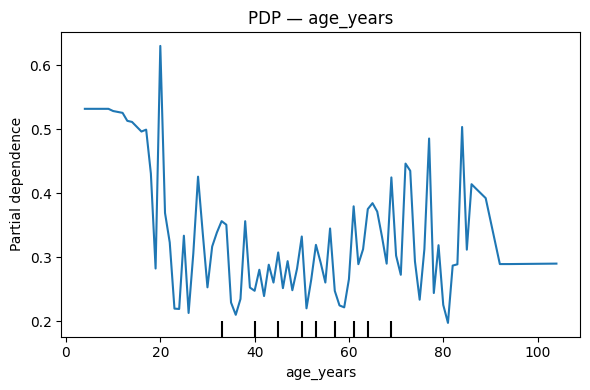

In [11]:
# ------------------------------------------------------------
# 7) Partial Dependence Plots (PDP)
# ------------------------------------------------------------
for feat in top3:
    fig, ax = plt.subplots(figsize=(6, 4))
    PartialDependenceDisplay.from_estimator(rf, X_train, [feat], ax=ax)
    plt.title(f"PDP — {feat}")
    plt.tight_layout()
    plt.show()